# Case Study - Treasury Repo Crisis: September 2019

#### Notation Commands

$$\newcommand{\Black}{\mathcal{B}}
\newcommand{\Blackcall}{\Black_{\mathrm{call}}}
\newcommand{\Blackput}{\Black_{\mathrm{put}}}
\newcommand{\EcondS}{\hat{S}_{\mathrm{conditional}}}
\newcommand{\Efwd}{\mathbb{E}^{T}}
\newcommand{\Ern}{\mathbb{E}^{\mathbb{Q}}}
\newcommand{\Tfwd}{T_{\mathrm{fwd}}}
\newcommand{\Tunder}{T_{\mathrm{bond}}}
\newcommand{\accint}{A}
\newcommand{\carry}{\widetilde{\cpn}}
\newcommand{\cashflow}{C}
\newcommand{\convert}{\phi}
\newcommand{\cpn}{c}
\newcommand{\ctd}{\mathrm{CTD}}
\newcommand{\disc}{Z}
\newcommand{\done}{d_{1}}
\newcommand{\dt}{\Delta t}
\newcommand{\dtwo}{d_{2}}
\newcommand{\flatvol}{\sigma_{\mathrm{flat}}}
\newcommand{\flatvolT}{\sigma_{\mathrm{flat},T}}
\newcommand{\float}{\mathrm{flt}}
\newcommand{\freq}{m}
\newcommand{\futprice}{\mathcal{F}(t,T)}
\newcommand{\futpriceDT}{\mathcal{F}(t+h,T)}
\newcommand{\futpriceT}{\mathcal{F}(T,T)}
\newcommand{\futrate}{\mathscr{f}}
\newcommand{\fwdprice}{F(t,T)}
\newcommand{\fwdpriceDT}{F(t+h,T)}
\newcommand{\fwdpriceT}{F(T,T)}
\newcommand{\fwdrate}{f}
\newcommand{\fwdvol}{\sigma_{\mathrm{fwd}}}
\newcommand{\fwdvolTi}{\sigma_{\mathrm{fwd},T_i}}
\newcommand{\grossbasis}{B}
\newcommand{\hedge}{\Delta}
\newcommand{\ivol}{\sigma_{\mathrm{imp}}}
\newcommand{\logprice}{p}
\newcommand{\logyield}{y}
\newcommand{\mat}{(n)}
\newcommand{\nargcond}{d_{1}}
\newcommand{\nargexer}{d_{2}}
\newcommand{\netbasis}{\tilde{\grossbasis}}
\newcommand{\normcdf}{\mathcal{N}}
\newcommand{\notional}{K}
\newcommand{\pfwd}{P_{\mathrm{fwd}}}
\newcommand{\pnl}{\Pi}
\newcommand{\price}{P}
\newcommand{\probexer}{\hat{\mathcal{P}}_{\mathrm{exercise}}}
\newcommand{\pvstrike}{K^*}
\newcommand{\refrate}{r^{\mathrm{ref}}}
\newcommand{\rrepo}{r^{\mathrm{repo}}}
\newcommand{\spotrate}{r}
\newcommand{\spread}{s}
\newcommand{\strike}{K}
\newcommand{\swap}{\mathrm{sw}}
\newcommand{\swaprate}{\cpn_{\swap}}
\newcommand{\tbond}{\mathrm{fix}}
\newcommand{\ttm}{\tau}
\newcommand{\value}{V}
\newcommand{\vega}{\nu}
\newcommand{\years}{\tau}
\newcommand{\yearsACT}{\tau_{\mathrm{act/360}}}
\newcommand{\yield}{Y}$$

## Introduction

On September 17, 2019, the overnight repo rate spiked to nearly 10%—the highest since the financial crisis. This case study walks through the mechanics of the Treasury basis trade during this episode, asking you to:

1. Calculate forward prices, implied repo rates, and net basis before the crisis
2. Analyze how the basis trade P&L evolved as repo rates spiked
3. Evaluate dynamic trading strategies in hindsight

Unlike the March 2020 COVID crisis, the September 2019 repo spike was short-lived—the Fed intervened within days and markets normalized. This provides a useful contrast for understanding how different types of market stress affect basis trade P&L.

***

# 1. The Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

### Data Description

The file `data/fut_bond_data_TYZ9_2019-09.xlsx` contains:
- `future`: TYZ9 (December 2019 10-Year Treasury futures) contract info as of September 13, 2019
- `bonds`: Deliverable basket with prices, coupons, conversion factors, and repo rates
- `daily`: Time series of futures prices, CTD prices, net basis, and SOFR through the crisis

In [3]:
FILE_DATA = 'data/fut_bond_data_TYZ9_2019-09.xlsx'

# Load the data
futdata = pd.read_excel(FILE_DATA, sheet_name='future').set_index('field')
bonds = pd.read_excel(FILE_DATA, sheet_name='bonds').set_index('ticker')
daily = pd.read_excel(FILE_DATA, sheet_name='daily', parse_dates=['date']).set_index('date')

# Key parameters
FACE = 100
DAYS_SETTLE = 1  # T+1 settlement
DAYS_TBILL_DENOM = 360  # ACT/360 convention

In [4]:
# Display futures contract info
futdata

,TYZ9
field,
last_update_dt,2019-09-13 00:00:00
px_last,128.578125
last_tradeable_dt,2019-12-19 00:00:00
fut_dlv_dt_last,2019-12-31 00:00:00
fut_days_expire,109
fut_ctd,T 1 7/8 06/30/26
fut_ctd_cf,0.7807
fut_ctd_gross_basis_32nds,-2.6887
fut_ctd_net_basis_32nds,1.1908


In [5]:
# Display deliverable basket
bonds[['name', 'cpn', 'maturity', 'px_last', 'conversion', 'repo_rate']]

,name,cpn,maturity,px_last,conversion,repo_rate
ticker,,,,,,
9128287B Govt,T 1 7/8 06/30/26,1.875,2026-06-30,100.296875,0.7807,2.2
912828Y9 Govt,T 1 7/8 07/31/26,1.875,2026-07-31,100.296875,0.7807,2.2
9128282A Govt,T 1 1/2 08/15/26,1.500,2026-08-15,97.851562,0.7607,2.2
912828YD Govt,T 1 3/8 08/31/26,1.375,2026-08-31,97.023438,0.7541,2.2
912828U2 Govt,T 2 11/15/26,2.000,2026-11-15,101.117188,0.7806,2.2
912828V9 Govt,T 2 1/4 02/15/27,2.250,2027-02-15,102.835938,0.7882,2.2
912828X8 Govt,T 2 3/8 05/15/27,2.375,2027-05-15,103.812500,0.7894,2.2
9128282R Govt,T 2 1/4 08/15/27,2.250,2027-08-15,102.906250,0.7762,2.2
9128283F Govt,T 2 1/4 11/15/27,2.250,2027-11-15,102.937500,0.7702,2.2


***

# 2. Setting Up the Trade (September 13, 2019)

### 2.1 Calculate the Forward Price

Using the CTD bond data and the repo rate, calculate the forward price for delivery at the futures expiration.

In [11]:
# 2.1 Forward price for CTD bond
ctd_name = futdata.loc['fut_ctd', 'TYZ9']
ctd = bonds[bonds['name'] == ctd_name].iloc[0]

px_clean = ctd['px_last']
ai_t = ctd['accrued_interest']
repo_rate = ctd['repo_rate'] / 100  # percent to decimal

days_to_delivery = int(futdata.loc['fut_days_expire', 'TYZ9'])
year_frac = days_to_delivery / DAYS_TBILL_DENOM

# dirty price today
p_dirty = px_clean + ai_t

# coupon accrual over holding period (clean)
coupon_rate = ctd['cpn'] / 100
coupon_accrual = coupon_rate * FACE * year_frac

# forward dirty price
f_dirty = p_dirty * (1 + repo_rate * year_frac) - coupon_accrual

# accrued interest at delivery (AI_T). For 2019-12-31, this is a coupon date for CTD, so AI_T≈0.
ai_T = 0.0

f_clean = f_dirty - ai_T

pd.Series({
    'futures_price': f_clean,
})


futures_price    100.424937
dtype: float64

### 2.2 Calculate the Implied Repo Rate

Given the futures price, calculate the implied repo rate. Compare it to the actual repo rate.

**Tip**: The implied repo rate is:

$$\text{repo}^{\text{implied}} = \left(\frac{\text{Price}_{\text{fut}} \cdot \text{CF} + \text{AI}_T}{P_t + \text{AI}_t} - 1\right) \cdot \frac{360}{\text{days}}$$

What is the implied repo rate, and how does it relate to net basis?

In [12]:
# 2.2 Implied repo rate
ctd_name = futdata.loc['fut_ctd', 'TYZ9']
ctd = bonds[bonds['name'] == ctd_name].iloc[0]

px_clean = ctd['px_last']
ai_t = ctd['accrued_interest']
p_dirty = px_clean + ai_t

cf = ctd['conversion']
fut_price = futdata.loc['px_last', 'TYZ9']

days_to_delivery = int(futdata.loc['fut_days_expire', 'TYZ9'])
year_frac = days_to_delivery / DAYS_TBILL_DENOM

# AI at delivery: for 2019-12-31 (coupon date) set to 0
ai_T = 0.0

# implied repo rate (decimal)
repo_implied = ((fut_price * cf + ai_T) / p_dirty - 1.0) / year_frac

actual_repo = ctd['repo_rate'] / 100

pd.Series({
    'repo_implied': repo_implied,
    'repo_actual': actual_repo,
})


repo_implied    0.001862
repo_actual     0.022000
dtype: float64

### 2.3 Calculate Gross Basis, Carry, and Net Basis

Calculate the basis components for the CTD bond.

**Tip**:
- **Gross basis**: $\grossbasis = P_t - \convert \cdot \futprice$
- **Carry**: $\text{carry} = (\cpn \cdot N - \rrepo \cdot P^{\text{dirty}}) \cdot \yearsACT$
- **Net basis**: $\netbasis = \grossbasis - \text{carry}$

In [17]:
# 2.3 Gross basis, carry, net basis (CTD)
ctd_name = futdata.loc['fut_ctd', 'TYZ9']
ctd = bonds[bonds['name'] == ctd_name].iloc[0]

px_clean = ctd['px_last']
ai_t = ctd['accrued_interest']
p_dirty = px_clean + ai_t

cf = ctd['conversion']
fut_price = futdata.loc['px_last', 'TYZ9']

days_to_delivery = int(futdata.loc['fut_days_expire', 'TYZ9'])
year_frac = days_to_delivery / DAYS_TBILL_DENOM

repo_rate = ctd['repo_rate'] / 100
coupon_rate = ctd['cpn'] / 100

gross_basis = px_clean - cf * fut_price
carry = (coupon_rate * FACE - repo_rate * p_dirty) * year_frac
net_basis = gross_basis - carry

basis_sign = 'positive' if net_basis > 0 else 'negative' if net_basis < 0 else 'zero'
cash_rel = 'expensive' if net_basis > 0 else 'cheap' if net_basis < 0 else 'fair'
trade = 'short cash / long future (reverse cash-and -carry)' if net_basis > 0 else 'long cash / short future (cash-and-carry)' if net_basis < 0 else 'no-arb'
 
pd.Series({ 
    'gross_basis': gross_basis,
    'carry': carry,
    'net_basis': net_basis,
    'net_basis_32nds': net_basis * 32,
    'net_basis_sign': basis_sign,
    'cash_relative_value': cash_rel,
    'suggested_trade': trade,
})


gross_basis                                                    -0.084067
carry                                                          -0.100563
net_basis                                                       0.016496
net_basis_32nds                                                 0.527881
net_basis_sign                                                  positive
cash_relative_value                                            expensive
suggested_trade        short cash / long future (reverse cash-and -ca...
dtype: object

Based on your analysis:
- Is net basis positive or negative?
- Does that mean "cash" (the bond) is expensive or cheap relative to the future?
- What trade does this suggest?

* The net basis is positive so cash is expensive so we short cash and long futures

***

# 3. The Blowup (September 16-19, 2019)

On September 16, 2019, repo rates began spiking. By the morning of September 17, overnight repo hit 10%—more than 4x the Fed's target rate. The cause: a confluence of quarterly corporate tax payments, Treasury settlement, and reserves having fallen to "scarcity" levels.

The Fed responded immediately with overnight repo operations (the first since 2008), injecting liquidity. By September 19, rates had normalized.

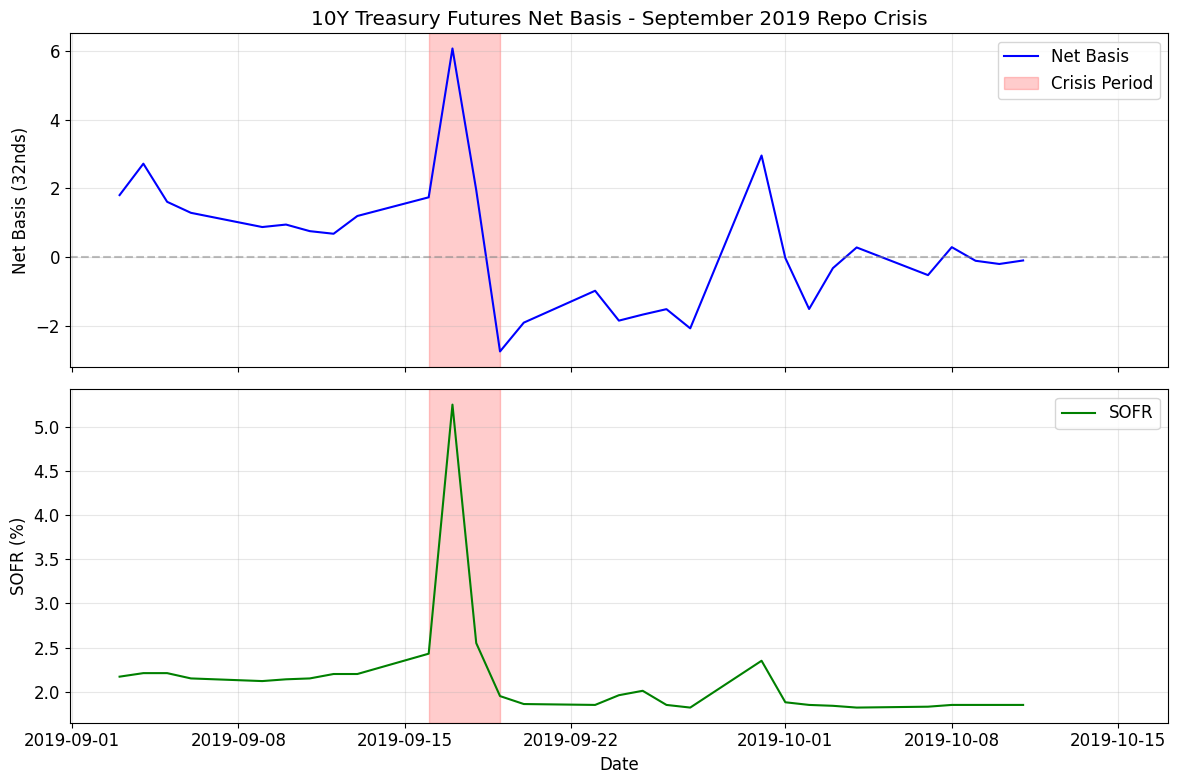

In [6]:
# Plot the crisis period - net basis and SOFR
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Net basis
ax1 = axes[0]
ax1.plot(daily.index, daily['net_basis_32nds'], 'b-', linewidth=1.5, label='Net Basis')
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.axvspan(pd.Timestamp('2019-09-16'), pd.Timestamp('2019-09-19'), alpha=0.2, color='red', label='Crisis Period')
ax1.set_ylabel('Net Basis (32nds)')
ax1.set_title('10Y Treasury Futures Net Basis - September 2019 Repo Crisis')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# SOFR
ax2 = axes[1]
ax2.plot(daily.index, daily['sofr'], 'g-', linewidth=1.5, label='SOFR')
ax2.axvspan(pd.Timestamp('2019-09-16'), pd.Timestamp('2019-09-19'), alpha=0.2, color='red')
ax2.set_ylabel('SOFR (%)')
ax2.set_xlabel('Date')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.1 Impact of Repo Spike on Carry and Net Basis

Compare the carry and net basis on September 13 (pre-crisis) vs September 17 (peak crisis).

When repo rates spike, what happens to:
- Carry?
- Net basis?
- A basis trader's P&L?

In [13]:
# 3.1 Carry and net basis around the repo spike
daily_calc = daily.copy()
daily_calc['carry_32nds'] = daily_calc['gross_basis_32nds'] - daily_calc['net_basis_32nds']

compare_dates = [pd.Timestamp('2019-09-13'), pd.Timestamp('2019-09-17')]
daily_calc.loc[compare_dates, ['gross_basis_32nds', 'carry_32nds', 'net_basis_32nds', 'sofr']]


,gross_basis_32nds,carry_32nds,net_basis_32nds,sofr
date,,,,
2019-09-13,-2.6887,-3.8795,1.1908,2.20
2019-09-17,-3.2579,-9.3283,6.0704,5.25


- Carry: worsens (more negative) because financing cost jumps.
- Net basis: typically drops (becomes more negative) as carry deteriorates.
- Basis trader P&L (long cash/short futures): loses as net basis widens negatively; mark‑to‑market drawdown increases.

### 3.2 Calculate P&L (September 13-19)

Consider a basis trader with the following position on September 13:
- **Notional**: $100 million (basis trade sized to match futures DV01)
- **Equity Capital**: Leveraged 50x via repo, so only $2 million of the long is our own capital.

We will analyze the **long cash bond / short futures** basis trade.

Calculate the mark-to-market (cumulative) P&L for **each date with data from Sep 13 through Sep 19** (inclusive).

Then the mark-to-market P&L from the net-basis move is:

$$
\Pi = \Delta\text{(net basis in 32nds)}\cdot \frac{\text{notional}}{100}\cdot \frac{1}{32}
$$

(For context on typical net basis magnitudes, see `discussions/4.X.1. Net Basis Analysis.ipynb`.)

In [14]:
# 3.2 P&L from net-basis move (Sep 13-19)
notional = 100_000_000
start_date = pd.Timestamp('2019-09-13')
end_date = pd.Timestamp('2019-09-19')

subset = daily.loc[start_date:end_date].copy()
nb0 = subset.loc[start_date, 'net_basis_32nds']
subset['delta_nb_32nds'] = subset['net_basis_32nds'] - nb0
subset['pnl'] = subset['delta_nb_32nds'] * (notional / 100.0) * (1/32)
subset[['net_basis_32nds', 'delta_nb_32nds', 'pnl']]


,net_basis_32nds,delta_nb_32nds,pnl
date,,,
2019-09-13,1.1908,0.0000,0.000
2019-09-16,1.7348,0.5440,17000.000
2019-09-17,6.0704,4.8796,152487.500
2019-09-18,1.9443,0.7535,23546.875
2019-09-19,-2.7552,-3.9460,-123312.500


### 3.3 P&L Through September 30

The Fed intervened on September 17. By September 19, repo rates had normalized.

Calculate and plot the cumulative P&L for **every date with data** from September 13 through September 30. What happened after the initial drawdown?

,net_basis_32nds,pnl
date,,
2019-09-24,-1.8574,-95256.250
2019-09-25,-1.6818,-89768.750
2019-09-26,-1.5232,-84812.500
2019-09-27,-2.0827,-102296.875
2019-09-30,2.9523,55046.875


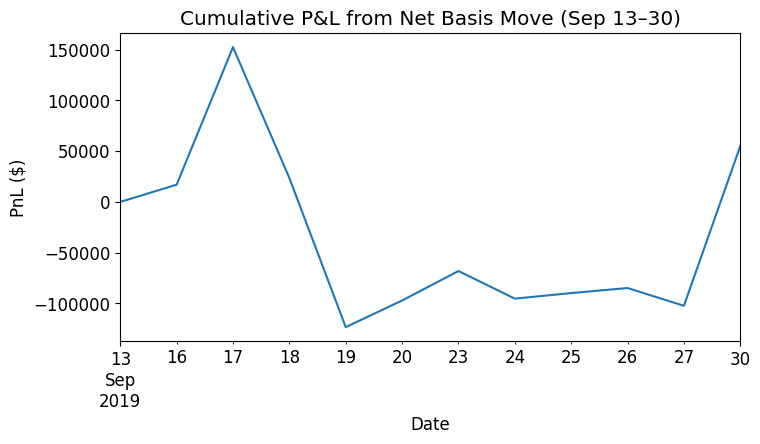

In [15]:
# 3.3 P&L from net-basis move (Sep 13-30)
notional = 100_000_000
start_date = pd.Timestamp('2019-09-13')
end_date = pd.Timestamp('2019-09-30')

subset = daily.loc[start_date:end_date].copy()
nb0 = subset.loc[start_date, 'net_basis_32nds']
subset['delta_nb_32nds'] = subset['net_basis_32nds'] - nb0
subset['pnl'] = subset['delta_nb_32nds'] * (notional / 100.0) * (1/32)

ax = subset['pnl'].plot(title='Cumulative P&L from Net Basis Move (Sep 13–30)', figsize=(8,4))
ax.set_ylabel('PnL ($)')
ax.set_xlabel('Date')

subset[['net_basis_32nds', 'pnl']].tail()


### 3.4 Max Drawdown

Report the max drawdown in terms of PnL or return on equity capital. On which date is it worst?

In [16]:
# 3.4 Max drawdown
notional = 100_000_000
equity = 2_000_000
start_date = pd.Timestamp('2019-09-13')
end_date = pd.Timestamp('2019-09-30')

subset = daily.loc[start_date:end_date].copy()
nb0 = subset.loc[start_date, 'net_basis_32nds']
subset['pnl'] = (subset['net_basis_32nds'] - nb0) * (notional / 100.0) * (1/32)
cum_pnl = subset['pnl']
running_max = cum_pnl.cummax()
drawdown = cum_pnl - running_max
max_dd = drawdown.min()
dd_date = drawdown.idxmin()

pd.Series({
    'max_drawdown_pnl': max_dd,
    'max_drawdown_date': dd_date,
    'max_drawdown_return_on_equity': max_dd / equity,
})


max_drawdown_pnl                           -275800.0
max_drawdown_date                2019-09-19 00:00:00
max_drawdown_return_on_equity                -0.1379
dtype: object

***